In [1]:
!pip install q keras==1.2.2

     |████████████████████████████████| 184kB 8.6MB/s 
  Created wheel for keras: filename=Keras-1.2.2-cp36-none-any.whl size=209603 sha256=8134d23284b82adcd0f164118709daed2e25481038306f7448c922afe57575e1
  Stored in directory: /root/.cache/pip/wheels/55/07/cf/b32db0a8d243b2fd6759d5d7cb650aa20670b2b740209cbf7e
Successfully built keras
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 1.2.2 which is incompatible.
ERROR: kapre 0.1.3.1 has requirement keras>=2.0.0, but you'll have keras 1.2.2 which is incompatible.
ERROR: fancyimpute 0.4.3 has requirement keras>=2.0.0, but you'll have keras 1.2.2 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [2]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior() 
!pip install tensorflow==1.4.0

     |████████████████████████████████| 41.2MB 107kB/s 
     |████████████████████████████████| 1.7MB 54.9MB/s 
     |████████████████████████████████| 890kB 48.5MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107222 sha256=bedf16ac77360c69bdb0d3c3bcf201526abe031e5232ea182020f8c2a3c4ec00
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
ERROR: fancyimpute 0.4.3 has requirement keras>=2.0.0, but you'll have keras 1.2.2 which is incompatible.
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.2.1
    Uninstalling bleach-3.2.1:
      Successfully uninstalled bleach-3.2.1
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob


def draw_test_img(imgs_path, model):
    images = [plt.imread(file) for file in glob.glob(imgs_path)]
    batch = np.array([np.transpose(cv2.resize(image[300:650, 500:, :], (448, 448)), (2, 0, 1))
                      for image in images])
    batch = 2 * (batch / 255.) - 1
    out = model.predict(batch)
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))
    for i, ax in zip(range(len(batch)), [ax1, ax2, ax3, ax4]):
        boxes = yolo_boxes(out[i], threshold=0.17)
        ax.imshow(draw_box(boxes, images[i], [[500, 1280], [300, 650]]))

    return out


def load_weights(model, yolo_weight_file):
    data = np.fromfile(yolo_weight_file, np.float32)
    data = data[4:]

    index = 0
    for layer in model.layers:
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape, bshape = shape
            bia = data[index:index + np.prod(bshape)].reshape(bshape)
            index += np.prod(bshape)
            ker = data[index:index + np.prod(kshape)].reshape(kshape)
            index += np.prod(kshape)
            layer.set_weights([ker, bia])


class Box:
    def __init__(self):
        self.x, self.y = float(), float()
        self.w, self.h = float(), float()
        self.c = float()
        self.prob = float()


def overlap(x1, w1, x2, w2):
    l1 = x1 - w1 / 2.
    l2 = x2 - w2 / 2.
    left = max(l1, l2)
    r1 = x1 + w1 / 2.
    r2 = x2 + w2 / 2.
    right = min(r1, r2)
    return right - left


def box_intersection(a, b):
    w = overlap(a.x, a.w, b.x, b.w)
    h = overlap(a.y, a.h, b.y, b.h)
    if w < 0 or h < 0:
        return 0
    area = w * h
    return area


def box_union(a, b):
    i = box_intersection(a, b)
    u = a.w * a.h + b.w * b.h - i
    return u


def box_iou(a, b):
    return box_intersection(a, b) / box_union(a, b)


def yolo_boxes(net_out, threshold=0.2, sqrt=1.8, C=20, B=2, S=7):
    classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair",
                "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant",
                "sheep", "sofa", "train","tvmonitor"]
    class_num = 6
    boxes = []
    SS = S * S  # number of grid cells
    prob_size = SS * C  # class probabilities
    conf_size = SS * B  # confidences for each grid cell

    probs = net_out[0: prob_size]
    confs = net_out[prob_size: (prob_size + conf_size)]
    cords = net_out[(prob_size + conf_size):]
    probs = probs.reshape([SS, C])
    confs = confs.reshape([SS, B])
    cords = cords.reshape([SS, B, 4])

    for grid in range(SS):
        for b in range(B):
            bx = Box()
            bx.c = confs[grid, b]
            bx.x = (cords[grid, b, 0] + grid % S) / S
            bx.y = (cords[grid, b, 1] + grid // S) / S
            bx.w = cords[grid, b, 2] ** sqrt
            bx.h = cords[grid, b, 3] ** sqrt
            p = probs[grid, :] * bx.c

            if p[class_num] >= threshold:
                bx.prob = p[class_num]
                boxes.append(bx)

    # combine boxes that are overlap
    boxes.sort(key=lambda b: b.prob, reverse=True)
    for i in range(len(boxes)):
        boxi = boxes[i]
        if boxi.prob == 0:
            continue
        for j in range(i + 1, len(boxes)):
            boxj = boxes[j]
            if box_iou(boxi, boxj) >= .4:
                boxes[j].prob = 0.
    boxes = [b for b in boxes if b.prob > 0.]

    return boxes


def draw_box(boxes, im, crop_dim):
    imgcv = np.copy(im)
    [xmin, xmax] = crop_dim[0]
    [ymin, ymax] = crop_dim[1]
    for i, b in enumerate(boxes, 1):
        h, w, _ = imgcv.shape
        left = int((b.x - b.w / 2.) * w)
        right = int((b.x + b.w / 2.) * w)
        top = int((b.y - b.h / 2.) * h)
        bot = int((b.y + b.h / 2.) * h)
        left = int(left * (xmax - xmin) / w + xmin)
        right = int(right * (xmax - xmin) / w + xmin)
        top = int(top * (ymax - ymin) / h + ymin)
        bot = int(bot * (ymax - ymin) / h + ymin)

        left = max(left, 0)
        right = min(right, w-1)
        top = max(top, 0)
        bot = min(bot, h-1)

        cv2.rectangle(imgcv, (left, top), (right, bot), (0, 0, 255), thickness=3)

        # draw label
        label = 'car ' + str(i)
        cv2.rectangle(imgcv, (left, top - 30), (right, top), (125, 125, 125), -1)
        cv2.putText(imgcv, label, (left + 5, top - 7), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1)

        # draw thumbnail in highlight title
        thumbnail = im[top:bot, left:right]
        vehicle_thumb = cv2.resize(thumbnail, dsize=(120, 80))  # width=120, height=80
        start_x = 750 + (i-1) * 30 + (i-1) * 120  # offset=30
        imgcv[60:60+80, start_x:start_x+120, :] = vehicle_thumb

    cv2.putText(imgcv, 'Lane', (280, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(imgcv, 'Detected Vehicles', (800, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2,
                cv2.LINE_AA)

    return imgcv


def draw_background_highlight(image, draw_img, w=1280):

    mask = cv2.rectangle(np.copy(image), (0, 0), (w, 155), (0, 0, 0), thickness=cv2.FILLED)

    return cv2.addWeighted(src1=mask, alpha=0.3, src2=draw_img, beta=0.8, gamma=0)


def draw_thumbnails(img_cp, img, window_list, thumb_w=120, thumb_h=80, off_x=30, off_y=30):
    cv2.putText(img_cp, 'Lane', (280, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(img_cp, 'Detected Vehicles', (600, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2, cv2.LINE_AA)
    for i, bbox in enumerate(window_list):
        thumbnail = img[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
        vehicle_thumb = cv2.resize(thumbnail, dsize=(thumb_w, thumb_h))
        start_x = 640 + (i+1) * off_x + i * thumb_w
        img_cp[off_y + 30:off_y + thumb_h + 30, start_x:start_x + thumb_w, :] = vehicle_thumb

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AtrousConvolution2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape
import time
# from helper_yolo import *


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3350528/45929032 bytes (7.3%)7503872/45929032 bytes (16.3%)11706368/45929032 bytes (25.5%)15736832/45929032 bytes (34.3%)19701760/45929032 bytes (42.9%)23805952/45929032 bytes (51.8%)27787264/45929032 bytes (60.5%)31727616/45929032 bytes (69.1%)35774464/45929032 bytes (77.9%)39878656/45929032 bytes (86.8%)43974656/45929032 bytes (95.7%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

Using TensorFlow backend.


In [3]:
 keras.backend.set_image_dim_ordering('th')
# # from keras import backend as K
# # K.tensorflow_backend.set_image_dim_ordering('th')
# from keras import backend as K
# K.common.set_image_dim_ordering('th')

In [4]:
model = Sequential()
model.add(Convolution2D(16, 3, 3,input_shape=(3, 448, 448), border_mode='same', subsample=(1, 1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 3, 3, border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), border_mode='valid'))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), border_mode='valid'))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), border_mode='valid'))
model.add(Convolution2D(256, 3, 3, border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), border_mode='valid'))
model.add(Convolution2D(512, 3, 3, border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), border_mode='valid'))
model.add(Convolution2D(1024, 3, 3, border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024, 3, 3, border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024, 3, 3, border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1470))

print('model loaded.')

model loaded.


In [5]:
 model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 448, 448)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 16, 448, 448)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 224, 224)  0           leakyrelu_1[0][0]                
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 224, 224)  4640        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [6]:
load_weights(model, '/content/drive/MyDrive/yolo/yolo-tiny.weights')
print('weight loaded.')

weight loaded.


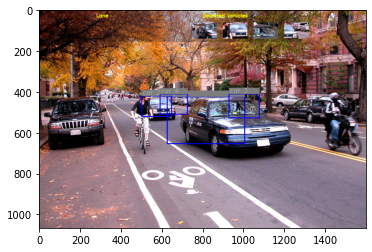

In [8]:
def process_image(image):
    crop = image[300:650, 500:, :]
    resized = cv2.resize(crop, (448, 448))
    batch = np.array([resized[:, :, 0], resized[:, :, 1], resized[:, :, 2]])
    batch = 2 * (batch/255.) - 1
    batch = np.expand_dims(batch, axis=0)
    out = model.predict(batch)
    boxes = yolo_boxes(out[0], threshold=0.2)
    # print(boxes[0])

    # draw result
    img_cp = np.copy(image)
    img_cp = draw_background_highlight(img_cp, image)
    img_cp = draw_box(boxes, np.copy(img_cp), [[500, 1280], [300, 650]])

    return img_cp

# input_path = '/content/drive/MyDrive/yolo/test3_licenseplate.mp4'
# video_output = '/content/drive/MyDrive/yolo/test_op.mp4'


# clip1 = VideoFileClip(input_path)
# # clip1 = VideoFileClip(input_path).subclip(29, 39)

# t = time.time()
# final_clip = clip1.fl_image(process_image)
# final_clip.write_videofile(video_output, audio=False)
# t2 = time.time()
# print(round(t2 - t, 2), 'Seconds to process video...')

image = mpimg.imread('/content/drive/MyDrive/yolo/car4.jpg')
plt.figure()
plt.imshow(process_image(image))
plt.show()

# DILATED MODEL TRY


In [9]:
model1 = Sequential()
model1.add(Convolution2D(16, 3, 3, input_shape=(3, 448, 448), border_mode='same', subsample=(1, 1)))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Convolution2D(32, 3, 3, border_mode='same'))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling2D(pool_size=(2, 2), border_mode='valid'))
model1.add(Convolution2D(64, 3, 3, border_mode='same'))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling2D(pool_size=(2, 2), border_mode='valid'))
model1.add(AtrousConvolution2D(128, 3, 3,atrous_rate=(2, 2), border_mode='same'))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling2D(pool_size=(2, 2), border_mode='valid'))
model1.add(AtrousConvolution2D(256, 3, 3,atrous_rate=(2, 2), border_mode='same'))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling2D(pool_size=(2, 2), border_mode='valid'))
model1.add(AtrousConvolution2D(512, 3, 3, atrous_rate=(2, 2), border_mode='same'))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling2D(pool_size=(2, 2), border_mode='valid'))
model1.add(Convolution2D(1024, 3, 3, border_mode='same'))
model1.add(LeakyReLU(alpha=0.1))
model1.add(Convolution2D(1024, 3, 3,  border_mode='same'))
model1.add(LeakyReLU(alpha=0.1))
model1.add(Convolution2D(1024, 3, 3,  border_mode='same'))
model1.add(LeakyReLU(alpha=0.1))
model1.add(Flatten())
model1.add(Dense(256))
model1.add(Dense(4096))
model1.add(LeakyReLU(alpha=0.1))
model1.add(Dense(1470))

print('model loaded.')

model loaded.


In [10]:
model1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_10 (Convolution2D) (None, 16, 448, 448)  448         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
leakyrelu_11 (LeakyReLU)         (None, 16, 448, 448)  0           convolution2d_10[0][0]           
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 16, 224, 224)  0           leakyrelu_11[0][0]               
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 32, 224, 224)  4640        maxpooling2d_7[0][0]             
___________________________________________________________________________________________

In [11]:
load_weights(model1, '/content/drive/MyDrive/yolo/yolo-tiny.weights')
print('weight loaded.')

weight loaded.


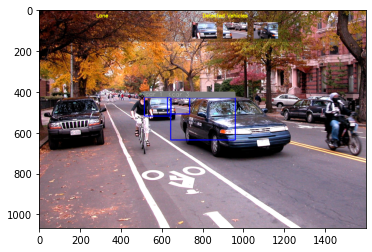

In [12]:
def process_image(image):
    crop = image[300:650, 500:, :]
    resized = cv2.resize(crop, (448, 448))
    batch = np.array([resized[:, :, 0], resized[:, :, 1], resized[:, :, 2]])
    batch = 2 * (batch/255.) - 1
    batch = np.expand_dims(batch, axis=0)
    out = model1.predict(batch)
    boxes = yolo_boxes(out[0], threshold=0.2)

    # draw result
    img_cp = np.copy(image)
    img_cp = draw_background_highlight(img_cp, image)
    img_cp = draw_box(boxes, np.copy(img_cp), [[500, 1280], [300, 650]])

    return img_cp

# input_path = '/content/drive/MyDrive/yolo/test3_licenseplate.mp4'
# video_output = '/content/drive/MyDrive/yolo/test_op.mp4'


# clip1 = VideoFileClip(input_path)
# # clip1 = VideoFileClip(input_path).subclip(29, 39)

# t = time.time()
# final_clip = clip1.fl_image(process_image)
# final_clip.write_videofile(video_output, audio=False)
# t2 = time.time()
# print(round(t2 - t, 2), 'Seconds to process video...')

image = mpimg.imread('/content/drive/MyDrive/yolo/car4.jpg')
plt.figure()
plt.imshow(process_image(image))
plt.show()